# TI3130: Classification Lab &mdash; Tutorial
**Julián Urbano &mdash; January 2022**

## 1. Introduction

The purpose of this lab is to introduce you to classification problems in Python. Just as we did in the _Regression_ lab, we will use package [Statsmodels](https://www.statsmodels.org/) when building classifiers for **understanding**, because it allows us to easily explore main effects, interactions or transformations through linear models. When building models for pure **prediction** purposes, we will use package [Scikitlearn](https://scikit-learn.org/), which provides a wide range of Machine Learning algorithms.

Scikit-learn is very much focused on predictive analysis rather than exploratory analysis. For example, it requires us to preprocess the data ourselves, so we have to:

1. Separate the response variable from the predictor variables.
2. Encode categorical predictors, usually through dummy variables (most algorithms only work with numerical features).
3. Compute interaction terms if desired.
4. Transform variables if desired.

Scikit-learn treats each column as a separate model term, so all this preprocessing work will be on us.

In [1]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

python 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)] 
numpy 1.21.2 
pandas 1.3.4 
plotnine 0.8.0 
statsmodels 0.13.0 
sklearn 1.0.1


As we did in previous labs, we will use the _Amsterdam lite_ dataset, which contains several data from neighborhoods in the city:

In [2]:
ams = pd.read_csv('amsterdam_lite.csv')
ams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   neighborhood      413 non-null    object 
 1   district          413 non-null    object 
 2   year              413 non-null    int64  
 3   fac_culture       413 non-null    int64  
 4   fac_sports        413 non-null    int64  
 5   fac_health        413 non-null    int64  
 6   fac_welfare       413 non-null    int64  
 7   fac_schools       413 non-null    int64  
 8   hou_corporation   413 non-null    int64  
 9   hou_occupant      413 non-null    int64  
 10  hou_other         413 non-null    int64  
 11  hou_value         413 non-null    int64  
 12  inc_income        413 non-null    int64  
 13  inc_gini          413 non-null    float64
 14  pop_total         413 non-null    int64  
 15  pop_unemployed    413 non-null    int64  
 16  saf_neighbors     413 non-null    object 
 1

## 2. A Note about Data

When inspecting the dataset structure above, we see that quite a few columns have the data type `object`, meaning that they contain character-like variables. When we work in classification problems, many libraries and algorithms require that the variables we predict are represented as [categorical variables](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) with a predefined vocabulary. Having a variable as a `category` can be achieved on a one-by-one basis using the [`Categorical`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Categorical.html) function from Pandas. The following code turns _every_ `object`-like column into a Pandas categorical column.

In [3]:
for col in ams.select_dtypes('object').columns:
    ams[col] = pd.Categorical(ams[col])
    
ams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   neighborhood      413 non-null    category
 1   district          413 non-null    category
 2   year              413 non-null    int64   
 3   fac_culture       413 non-null    int64   
 4   fac_sports        413 non-null    int64   
 5   fac_health        413 non-null    int64   
 6   fac_welfare       413 non-null    int64   
 7   fac_schools       413 non-null    int64   
 8   hou_corporation   413 non-null    int64   
 9   hou_occupant      413 non-null    int64   
 10  hou_other         413 non-null    int64   
 11  hou_value         413 non-null    int64   
 12  inc_income        413 non-null    int64   
 13  inc_gini          413 non-null    float64 
 14  pop_total         413 non-null    int64   
 15  pop_unemployed    413 non-null    int64   
 16  saf_neighbors     413 non-

We can see that categorical columns now have data type `category`. We can work with these columns knowing that there is an underlying vocabulary. In fact, when printing a categorical column we can see the full vocabulary and the order of the classes.

In [4]:
ams['spa_streets']

0      2.average
1      2.average
2          1.low
3      2.average
4      2.average
         ...    
408    2.average
409    2.average
410    2.average
411    2.average
412    2.average
Name: spa_streets, Length: 413, dtype: category
Categories (3, object): ['1.low', '2.average', '3.high']

The vocabulary can be accessed directly via `ams['spa_streets'].cat.categories`. In addition, categorical variables are internally encoded as integers, assigning each class to a different integer. This encoding will prove useful in some cases, and can be obtained via `ams['spa_streets'].cat.codes`.

We must note three details about the default behavior of `Categorical`:

1. It will set the vocabulary equal to the unique values in the list. If the vocabulary contemplates other possibilities not contained in the list, we have to specify the full vocabulary through argument `categories`. Consider the following example, in which the first call to `Categorical` results in an incomplete vocabulary:

In [5]:
# sample data
vowels = ['a', 'a', 'o', 'i']
# incomplete vocabulary
print(pd.Categorical(vowels))
# complete vocabulary
print(pd.Categorical(vowels, categories = ['a', 'e', 'i', 'o', 'u']))

['a', 'a', 'o', 'i']
Categories (3, object): ['a', 'i', 'o']
['a', 'a', 'o', 'i']
Categories (5, object): ['a', 'e', 'i', 'o', 'u']


2. The vocabulary will be sorted alphabetically by default. If we want to sort it in some other way for visualization purposes, or to tell which levels will be considered `low`/`high`, or `success`/`failure`, we have to indicate such order explicitly. Compare the resulting vocabularies in the following example:

In [6]:
# sample data
safety = ['low', 'low', 'high']
# unsorted vocabulary
print(pd.Categorical(safety))
# sorted vocabulary
print(pd.Categorical(safety, categories = ['low', 'high']))

['low', 'low', 'high']
Categories (2, object): ['high', 'low']
['low', 'low', 'high']
Categories (2, object): ['low', 'high']


3. If the variable represents an ordinal variable, we should specify the order in the vocabulary and indicate that this is an ordered variable.

In [7]:
# sample data
safety = ['low', 'low', 'average', 'high']
# unsorted vocabulary
print(pd.Categorical(safety))
# sorted vocabulary, nominal measurement
print(pd.Categorical(safety, categories = ['low', 'average', 'high']))
# sorted vocabulary, ordinal measurement
print(pd.Categorical(safety, categories = ['low', 'average', 'high'], ordered = True))

['low', 'low', 'average', 'high']
Categories (3, object): ['average', 'high', 'low']
['low', 'low', 'average', 'high']
Categories (3, object): ['low', 'average', 'high']
['low', 'low', 'average', 'high']
Categories (3, object): ['low' < 'average' < 'high']


In classification problems, we typically want the response variable to at least be represented as a categorical, and setting a specific order for the vocabulary, or even identifying the variable as an ordinal measurement will help us avoid mistakes and simplify our code.

## 3. Evaluation Metrics

Throughout this lab we will be measuring the performance of classification models in terms of their accuracy, precision, recall and F-score. We can implement these metrics ourselves, but for simplicity we will use the implementation in the Scikit-learn package.

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

To allow for easy evaluation, we may also use Scikit-learn to create a full classification report and a confusion matrix:

In [9]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

## 4. Logistic Regression for Classification

In the _Regression_ lab we used library Statsmodels to fit logistic regression models for a numerical response between 0 and 1. We can use the same class of models to build a classifier for a binary response, coded as 0 or 1 for semantics like `failure/success`, `no/yes`, `low/high`, etc.

Let us try and build a classifier for `saf_neighbors` using `hou_value` as sole predictor. The first thing we should do is create a binary response, say `y`, making sure that it properly encodes `1.low` as 0 and `2.high` as 1. Because we made `saf_neighbors` a categorical variable which, by default, sorts the vocabulary alphabetically, this can be done quite easily (the `num.name` coding is purposefully used for this reason):

In [10]:
# create a binary response variable y
ams['y'] = ams['saf_neighbors'].cat.codes
# check correspondence with the original variable
pd.crosstab(ams['y'], ams['saf_neighbors'])

saf_neighbors,1.low,2.high
y,,
0,147,0
1,0,266


A logistic model will thus represent the probability of `2.high` given the features, that is, $P(Y=high|X)$. If we wanted to do it the other way around and predict $P(Y=low|X)$, we could reverse the levels of `saf_neighbors` when creating the response `y`.

Let us build the logistic model:

In [11]:
m = smf.glm('y ~ hou_value', ams, family = sm.families.Binomial()).fit()
m.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.3292,0.343,-3.877,0.000,-2.001,-0.657
hou_value,8.117e-06,1.45e-06,5.580,0.000,5.27e-06,1.1e-05


We can see a significant effect of `hou_value` indeed, but let's plot the model. We can directly plot $P(Y=high|X)$:

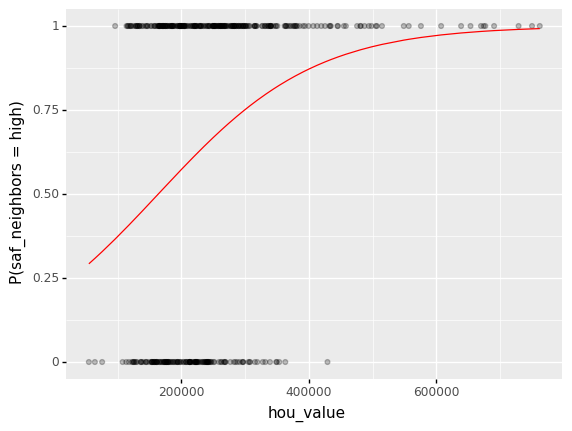

<ggplot: (14445758)>

In [12]:
d = ams.assign(_fittedvalues = m.fittedvalues)

ggplot(d, aes('hou_value', 'y')) +\
    geom_point(alpha = .25) +\
    geom_line(aes(y = '_fittedvalues'), color = 'red') +\
    labs(y = 'P(saf_neighbors = high)')

It looks like the model does not do a very good job and will misclassify most of the `1.low` instances, so let's look at evaluation metrics. To compute them, we need the prediction of the class, so let's compute it from the probabilistic output of the model by using a default threshold of 0.5:

In [13]:
# this is a probabilistic prediction
p = m.predict()
# this will compute the predicted class based on the threshold 0.5
p = ams['saf_neighbors'].cat.categories[np.where(p < .5, 0, 1)]

print('Accuracy: ', accuracy_score(ams['saf_neighbors'], p))
print('Precision: ', precision_score(ams['saf_neighbors'], p, pos_label = '2.high'))
print('Recall: ', recall_score(ams['saf_neighbors'], p, pos_label = '2.high'))

Accuracy:  0.6537530266343826
Precision:  0.6782608695652174
Recall:  0.8796992481203008


Note how, for precision and recall, we explicitly indicated which of the two classes is considered the positive one. We can instead look at a complete report per class:

In [14]:
print(classification_report(ams['saf_neighbors'], p))

              precision    recall  f1-score   support

       1.low       0.53      0.24      0.33       147
      2.high       0.68      0.88      0.77       266

    accuracy                           0.65       413
   macro avg       0.60      0.56      0.55       413
weighted avg       0.63      0.65      0.61       413



We can see that, indeed, the recall of the `1.low` class is very low. This would call for a sensible tuning of the threshold hyperparameter if such a recall was a problem for our needs.

Note that the classification report contains a row named `macro avg`. This corresponds to the macro-averaged metric score, that is, the metric score averaged over classes. This will be the proper statistic to report overall performance for a specific metric in a multi-class scenario.

Of course, we can include more predictors just in the same way we include them in any other regression model. Let's try with the `district`:

In [15]:
m = smf.glm('y ~ hou_value + district', ams, family = sm.families.Binomial()).fit()
m.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.1707,0.842,-3.767,0.000,-4.821,-1.521
district[T.E West],-0.8195,0.533,-1.538,0.124,-1.864,0.225
district[T.F Nieuw-West],1.5104,0.604,2.501,0.012,0.327,2.694
district[T.K Zuid],-1.0079,0.531,-1.900,0.057,-2.048,0.032
district[T.M Oost],0.7963,0.574,1.386,0.166,-0.330,1.922
district[T.N Noord],0.4525,0.608,0.745,0.456,-0.738,1.643
district[T.T Zuidoost],1.8824,0.682,2.758,0.006,0.545,3.220
hou_value,1.508e-05,2.45e-06,6.161,0.000,1.03e-05,1.99e-05


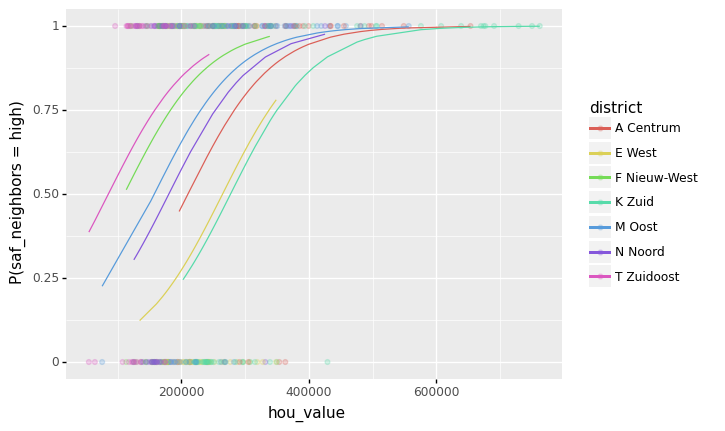

<ggplot: (15094839)>

In [16]:
d = ams.assign(_fittedvalues = m.fittedvalues)

ggplot(d, aes('hou_value', 'y', color = 'district')) +\
    geom_point(alpha = .25) +\
    geom_line(aes(y = '_fittedvalues')) +\
    labs(y = 'P(saf_neighbors = high)')

It appears that including the `district` should help quite a bit. Let's compute evaluation metrics to confirm:

In [17]:
p = m.predict()
p = ams['saf_neighbors'].cat.categories[np.where(p < .5, 0, 1)]

print(classification_report(ams['saf_neighbors'], p))

              precision    recall  f1-score   support

       1.low       0.64      0.56      0.59       147
      2.high       0.77      0.82      0.80       266

    accuracy                           0.73       413
   macro avg       0.70      0.69      0.70       413
weighted avg       0.72      0.73      0.72       413



Indeed, the overall accuracy increases, but the most important change we can notice in the recall of the `1.low` class, which raises from 24% to 56%.

## 5. Multinomial Regression for Classification

Logistic regression may be used for binary classification problems, but for multi-class problems we would need to resort to multinomial classification. This can be done with library Statsmodels as well. Models are specified and trained in a very similar fashion using the [`formula_api`](https://www.statsmodels.org/dev/example_formulas.html) to easily specify main effects, interactions, etc. However, we use  function [`mnlogit`](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.mnlogit.html), which requires us to encode our response variable as integers, each corresponding to a class. This can be easily done with Pandas categorical variables, as we saw earlier.

Let’s try to predict `spa_streets` using predictors about housing (`hou_*`) and all their two-factor interactions, and income (`inc_*`):

In [18]:
ams['y'] = ams['spa_streets'].cat.codes
pd.crosstab(ams['y'], ams['spa_streets'])

spa_streets,1.low,2.average,3.high
y,,,
0,112,0,0
1,0,240,0
2,0,0,61


In [19]:
m = smf.mnlogit('y ~ (hou_corporation + hou_occupant + hou_other + hou_value)**2 + inc_income + inc_gini', ams).fit()
m.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.806086
         Iterations 8


y=1,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.0617,1.461,1.412,0.158,-0.801,4.925
hou_corporation,-0.0030,0.001,-2.865,0.004,-0.005,-0.001
hou_occupant,-0.0006,0.003,-0.213,0.831,-0.006,0.005
hou_other,0.0006,0.002,0.293,0.770,-0.003,0.005
hou_value,-2.235e-06,5.92e-06,-0.377,0.706,-1.38e-05,9.37e-06
hou_corporation:hou_occupant,4.693e-07,1.54e-06,0.306,0.760,-2.54e-06,3.48e-06
hou_corporation:hou_other,1.063e-06,1.59e-06,0.670,0.503,-2.05e-06,4.17e-06
hou_corporation:hou_value,8.319e-09,4.93e-09,1.686,0.092,-1.35e-09,1.8e-08
hou_occupant:hou_other,-2.25e-06,1.62e-06,-1.385,0.166,-5.44e-06,9.35e-07
hou_occupant:hou_value,1.156e-08,9.46e-09,1.222,0.222,-6.98e-09,3.01e-08


If we make predictions for the training data we get the probability of each class in an array, with one column per class and one row per instance:

In [20]:
p = m.predict()
p

array([[0.03107858, 0.68075156, 0.28816986],
       [0.18601459, 0.57483867, 0.23914674],
       [0.12671799, 0.56747937, 0.30580264],
       ...,
       [0.01657096, 0.4063005 , 0.57712854],
       [0.38538115, 0.59407657, 0.02054228],
       [0.18642854, 0.70463869, 0.10893277]])

In order to compute evaluation metrics we need to predict the class with the highest probability, which can be easily achieved with Numpy's [`argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function, along with the vocabulary of the response:

In [21]:
p = ams['spa_streets'].cat.categories[np.argmax(p, axis = 1)]

print(classification_report(ams['spa_streets'], p))

              precision    recall  f1-score   support

       1.low       0.58      0.28      0.38       112
   2.average       0.60      0.88      0.72       240
      3.high       0.27      0.05      0.08        61

    accuracy                           0.59       413
   macro avg       0.49      0.40      0.39       413
weighted avg       0.55      0.59      0.53       413



It looks like the model is having trouble predicting class `3.high`, given the low recall value. Let's take a look at a confusion matrix to see what kinds of mistakes are made by the model:

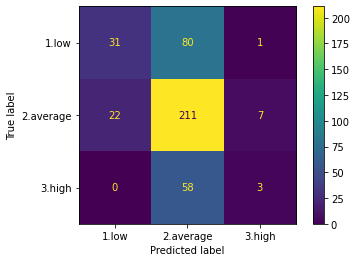

In [22]:
ConfusionMatrixDisplay.from_predictions(ams['spa_streets'], p, labels = ams['spa_streets'].cat.categories)

Consider using argument [`normalize`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) to look at conditional proportions in the confusion matrix, such as fraction over truth, or fraction over predicted.

It's clear that the model is biased towards the majority class `2.average`. For class `1.low` the model predicts `2.average` 71% of the times, but for class `3.high` there is no sensitivity and the model predicts `2.average` 95% of the times. In this case we would need to deal with the class imbalance, for example by weighting every instance in the training set (refer to the additional readings from the _Classification_ lecture)

## 6. Trees

To work with decision trees we will use Scikit-learn.

In [23]:
from sklearn import tree

Let us build a tree classifier to predict `spa_streets` with all features about number of facilities in a neighborhood (`fac_*`), safety (`saf_*`) and income (`inc_*`). We first need to create a response column `y` with `spa_streets`, as well as feature matrix `X` with all features:

In [24]:
y = ams['spa_streets']
X = ams.filter(regex = '^(fac_|saf_|inc_)')
# use Pandas to create dummy variables for us
X = pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fac_culture              413 non-null    int64  
 1   fac_sports               413 non-null    int64  
 2   fac_health               413 non-null    int64  
 3   fac_welfare              413 non-null    int64  
 4   fac_schools              413 non-null    int64  
 5   inc_income               413 non-null    int64  
 6   inc_gini                 413 non-null    float64
 7   saf_neighbors_1.low      413 non-null    uint8  
 8   saf_neighbors_2.high     413 non-null    uint8  
 9   saf_nonneighbors_1.low   413 non-null    uint8  
 10  saf_nonneighbors_2.high  413 non-null    uint8  
 11  saf_catering_1.low       413 non-null    uint8  
 12  saf_catering_2.high      413 non-null    uint8  
dtypes: float64(1), int64(6), uint8(6)
memory usage: 25.1 KB


Note how the safety variables in the dataset have turned into dummy variables in the feature matrix `X` thanks to function [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) in Pandas. We can now use this feature matrix and response vector to train a model with [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) in Scikit-learn. Let us train a decision tree and evaluate its performance on the training data:

              precision    recall  f1-score   support

       1.low       1.00      1.00      1.00       112
   2.average       1.00      1.00      1.00       240
      3.high       1.00      1.00      1.00        61

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413



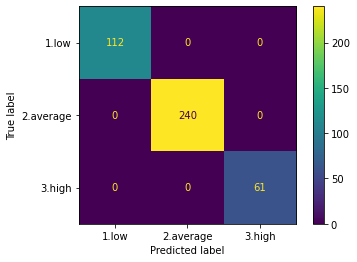

In [25]:
# train
c_full = tree.DecisionTreeClassifier()
m_full = c_full.fit(X, y)

# predict
p = m_full.predict(X)

# evaluate
print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p, labels = y.cat.categories)

(At this point you could consider implementing your own function to evaluate a model and display a confusion matrix in one line, instead of copy-pasting the same code multiple times; try it as an exercise). We have perfect predictive performance! This is highly unusual, unless of course, we are overfitting (see section _Cross-validation_ below). Let's check basic properties of the tree:

In [26]:
print('Tree depth: ', m_full.get_depth())
print('Number of leaves: ', m_full.get_n_leaves())

Tree depth:  14
Number of leaves:  122


This is a pretty big tree indeed. We have around 120 leaf nodes to predict only 3 classes in a dataset with around 400 instances.

Let's try to visualize the tree. We can first attempt a graphical visualization through [Graphviz](https://graphviz.org/), which allows us to render the tree in the Jupyter notebook itself. Check the [online documentation](https://graphviz.org/download/) for installation instructions, and then install the Python wrappers from your Conda environment:

```
$ conda install graphviz
$ conda install python-graphviz
```

Once installed (if you don't manage to install Graphviz you can just ignore it; a text-based visualization is still possible), we can render the tree as follows:

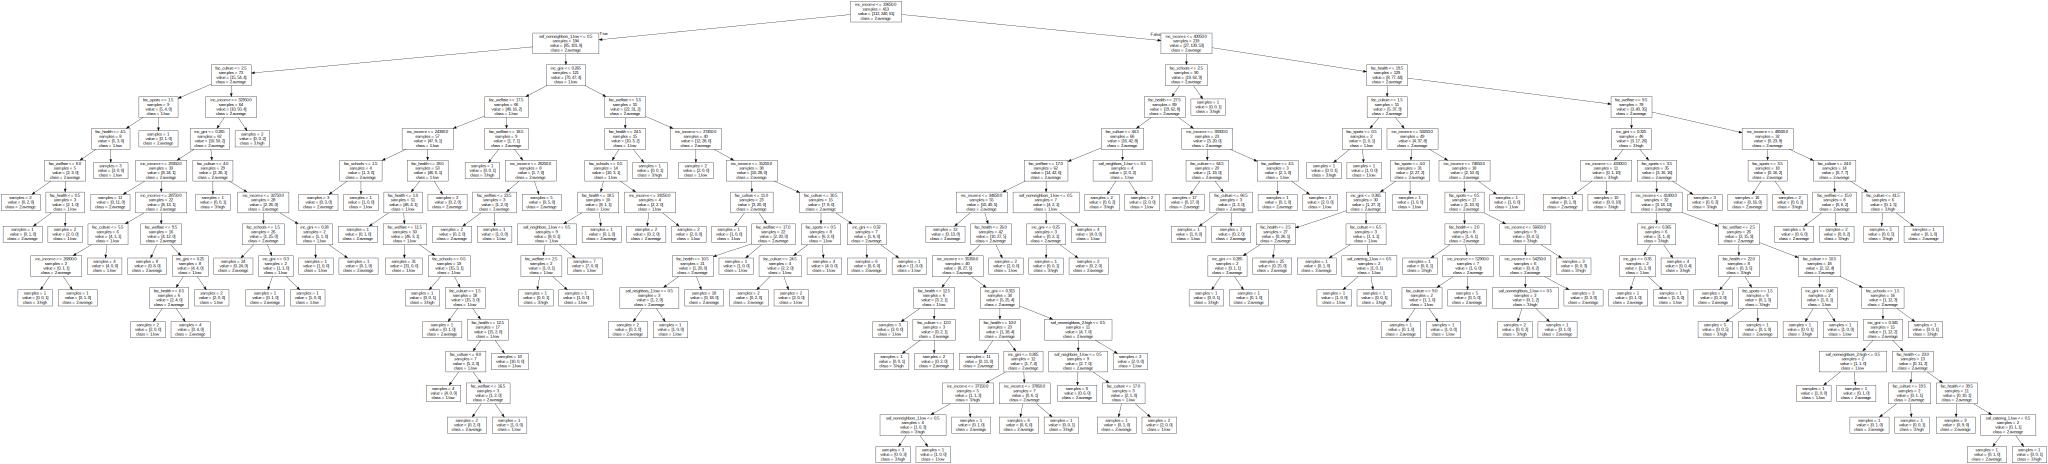

In [27]:
import graphviz

dot_data = tree.export_graphviz(m_full, feature_names = X.columns.array, class_names = y.cat.categories,
                                impurity = False, node_ids = False)
graphviz.Source(dot_data)

In each node we first find the branch condition, followed by the number of instances in the training data that fall under the branch, the class distribution, and what the majority class is (ie. the prediction).

Alternatively, we can generate an image file in a standard format like PNG or PDF:

In [28]:
graph = graphviz.Source(dot_data, format = 'png') 
graph.render('m_full')

'm_full.png'

![m_full.png](m_full.png)

We can also try to visualize the tree via a textual description:

In [29]:
print(tree.export_text(m_full, feature_names = X.columns.array, show_weights = True))

|--- inc_income <= 33650.00
|   |--- saf_nonneighbors_1.low <= 0.50
|   |   |--- fac_culture <= 2.50
|   |   |   |--- fac_sports <= 1.50
|   |   |   |   |--- fac_health <= 4.50
|   |   |   |   |   |--- fac_welfare <= 6.00
|   |   |   |   |   |   |--- weights: [0.00, 2.00, 0.00] class: 2.average
|   |   |   |   |   |--- fac_welfare >  6.00
|   |   |   |   |   |   |--- fac_health <= 0.50
|   |   |   |   |   |   |   |--- weights: [0.00, 1.00, 0.00] class: 2.average
|   |   |   |   |   |   |--- fac_health >  0.50
|   |   |   |   |   |   |   |--- weights: [2.00, 0.00, 0.00] class: 1.low
|   |   |   |   |--- fac_health >  4.50
|   |   |   |   |   |--- weights: [3.00, 0.00, 0.00] class: 1.low
|   |   |   |--- fac_sports >  1.50
|   |   |   |   |--- weights: [0.00, 1.00, 0.00] class: 2.average
|   |   |--- fac_culture >  2.50
|   |   |   |--- inc_income <= 32950.00
|   |   |   |   |--- inc_gini <= 0.27
|   |   |   |   |   |--- inc_income <= 25950.00
|   |   |   |   |   |   |--- weights: [0.00,

### 6.1. Pruning

Our tree `m_full` is probably overfitted, so we should try and prune it to simplify (actually, in Scikit-learn we don't prune an existing tree, but rather retrain it with one or more hyperparameters that restrict how much it grows). Let's restrict the maximum depth to half of what we initially had:

Tree depth:  7
Number of leaves:  62
              precision    recall  f1-score   support

       1.low       0.87      0.80      0.84       112
   2.average       0.86      0.94      0.90       240
      3.high       0.87      0.66      0.75        61

    accuracy                           0.86       413
   macro avg       0.87      0.80      0.83       413
weighted avg       0.86      0.86      0.86       413



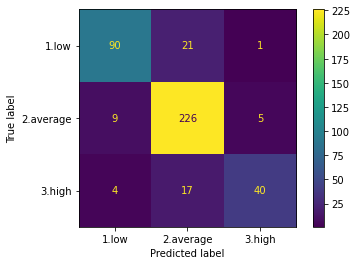

In [30]:
# train
c_depth_7 = tree.DecisionTreeClassifier(max_depth = 7)
m_depth_7 = c_depth_7.fit(X, y)

print('Tree depth: ', m_depth_7.get_depth())
print('Number of leaves: ', m_depth_7.get_n_leaves())

# predict
p = m_depth_7.predict(X)

# evaluate
print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p, labels = y.cat.categories)

We can see that the tree is considerably smaller, and still achieves an accuracy above 85%. Let's now restrict the number of leaf nodes:

Tree depth:  8
Number of leaves:  25
              precision    recall  f1-score   support

       1.low       0.82      0.62      0.71       112
   2.average       0.75      0.95      0.84       240
      3.high       0.96      0.39      0.56        61

    accuracy                           0.78       413
   macro avg       0.84      0.65      0.70       413
weighted avg       0.80      0.78      0.76       413



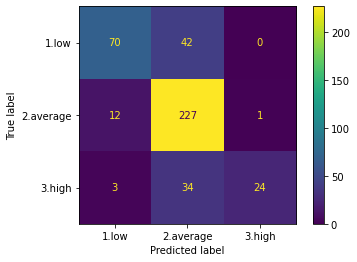

In [31]:
# train
c_leafs_25 = tree.DecisionTreeClassifier(max_leaf_nodes = 25)
m_leafs_25 = c_leafs_25.fit(X, y)

print('Tree depth: ', m_leafs_25.get_depth())
print('Number of leaves: ', m_leafs_25.get_n_leaves())

# predict
p = m_leafs_25.predict(X)

# evaluate
print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p, labels = y.cat.categories)

The resulting tree is even smaller, but accuracy is further reduced below 80%. In particular, we can see that performance on the minority class `3.high` has lowered the most. Still, this tree might be a better candidate because of its simplicity. Let's visualize it:

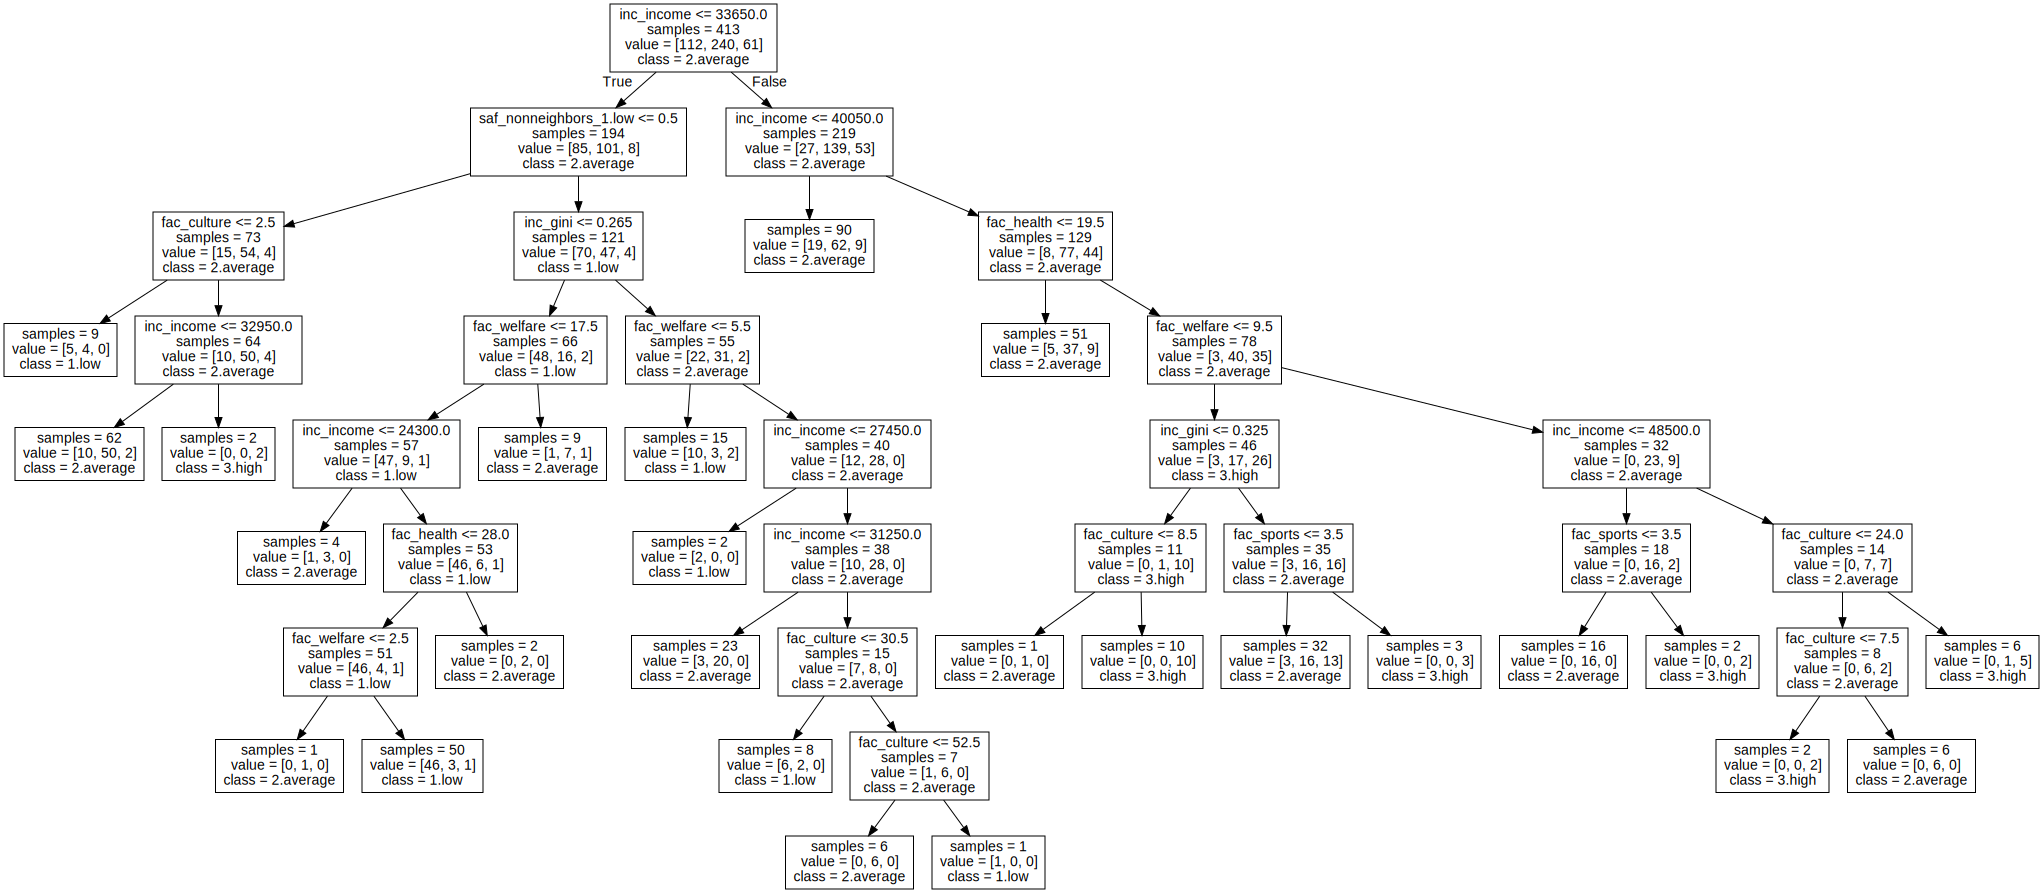

In [32]:
dot_data = tree.export_graphviz(m_leafs_25, feature_names = X.columns.array, class_names = y.cat.categories,
                                impurity = False, node_ids = False)
graphviz.Source(dot_data)

In [33]:
graph = graphviz.Source(dot_data, format = 'png') 
graph.render('m_leafs_25')

'm_leafs_25.png'

![m_leafs_25.png](m_leafs_25.png)

There are other hyperparameters to control the learning process. Check out the documentation of [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

### 6.2. Bagging and Random Forests

To work with bagging and random forests we will use [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) and [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), respectively: 

In [34]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

The difference between bagging and random forests is just in how many features are used to decide where to create a new branch of a tree: all $p$ features for bagging, or some number $m<p$ for random forests. We can specify $m$ through argument `max_features` (by default it will use $m=\sqrt{p}$). In addition, we may specify argument `n_estimators` for a custom number of trees to train:

In [35]:
# bagging
c_bag = BaggingClassifier(n_estimators = 10)
m_bag = c_bag.fit(X, y)

# random forest
c_rf = RandomForestClassifier(n_estimators = 10, max_features = 3)
m_rf = c_rf.fit(X, y)

Let us compare the predictions with those of the full tree `m_full` and the pruned tree `m_leafs_25`:

In [36]:
p_full = m_full.predict(X)
p_leafs_25 = m_leafs_25.predict(X)
p_bag = m_bag.predict(X)
p_rf = m_rf.predict(X)

print('F-score m_full: ', f1_score(y, p_full, average = 'macro'))
print('F-score m_leafs_25: ', f1_score(y, p_leafs_25, average = 'macro'))
print('F-score m_bag: ', f1_score(y, p_bag, average = 'macro'))
print('F-score m_rf: ', f1_score(y, p_rf, average = 'macro'))

F-score m_full:  1.0
F-score m_leafs_25:  0.7016317325444793
F-score m_bag:  0.9801449911066253
F-score m_rf:  0.9815921430906024


We can see that both bagging and random forest perform exceptionally well with just 10 trees per model. Could this measurement of performance be misleading? Section _Cross-validation_ will illustrate performance on unseen datasets, and how training and testing on the same data, as we have done this far, is not a good idea.

### 6.3. A Note about Randomization

Some algorithms like random forests use randomization, for instance to select feature at each branch. Because this step is random, the tree is also random to some degree, so the final model may differ from one run of the algorithm to another. To illustrate, let's fit a random forest model to the same data, five different times, and compare results.

In [37]:
for i in range(5):
    c = RandomForestClassifier(n_estimators = 10, max_features = 3)
    m = c.fit(X, y)
    p = m.predict(X)
    
    print('F-score ', f1_score(y, p, average = 'macro'))

F-score  0.9891637959961458
F-score  0.9699087507253917
F-score  0.9865349965349965
F-score  0.9749989225709909
F-score  0.9808986133096805


As we can see, the results are slightly different, because each random initialization is different. With a careful configuration of hyperparameters, most of the times these differences will have little effect, but they will effectively make our work irreproducible: if we want to re-run something it will lead to different results each time (imagine re-running the same Jupyter notebook and having a different result each time).

To prevent this from happening, we need to fix the state of the randomization engine of the computer before running the algorithm. This is because the [randomization engine is not really random](https://en.wikipedia.org/wiki/Pseudorandom_number_generator), but rather depends on the state in which it is at that moment. If we fix the state to some arbitrary value, we guarantee that all subsequent random-like analysis will yield the same results. We can do this with argument `random_state`:

In [38]:
for i in range(5):
    # Use some arbitrary number, like 12345, and keep it the same
    c = RandomForestClassifier(n_estimators = 10, max_features = 3, random_state = 12345)
    m = c.fit(X, y)
    p = m.predict(X)
    
    print('F-score ', f1_score(y, p, average = 'macro'))

F-score  0.9799905656959446
F-score  0.9799905656959446
F-score  0.9799905656959446
F-score  0.9799905656959446
F-score  0.9799905656959446


We can see that all results are the same now. 

## 7. Support Vector Machines

To work with SVMs, we will use [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (Support Vector Classification) from Scikit-learn:

In [39]:
from sklearn.svm import SVC

It's usually a good idea to scale the dataset before training an SVM, so that we prevent the model from being biased towards variables with high variance. The usual scaling consists in standardizing every column to unit variance and zero mean, which we can easily achieve via [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html):

In [40]:
from sklearn.preprocessing import StandardScaler

# "learn" how to scale from the training data
scaler = StandardScaler().fit(X)
# scale the feature matrix X and turn into a Pandas dataframe
X_prime = scaler.transform(X)
X_prime = pd.DataFrame.from_records(X_prime, columns = X.columns)

X_prime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fac_culture              413 non-null    float64
 1   fac_sports               413 non-null    float64
 2   fac_health               413 non-null    float64
 3   fac_welfare              413 non-null    float64
 4   fac_schools              413 non-null    float64
 5   inc_income               413 non-null    float64
 6   inc_gini                 413 non-null    float64
 7   saf_neighbors_1.low      413 non-null    float64
 8   saf_neighbors_2.high     413 non-null    float64
 9   saf_nonneighbors_1.low   413 non-null    float64
 10  saf_nonneighbors_2.high  413 non-null    float64
 11  saf_catering_1.low       413 non-null    float64
 12  saf_catering_2.high      413 non-null    float64
dtypes: float64(13)
memory usage: 42.1 KB


Let's build an SVM classifier with a quadratic polynomial kernel:

Number of Support Vectors:  [108 162  61]
              precision    recall  f1-score   support

       1.low       0.78      0.28      0.41       112
   2.average       0.63      0.95      0.76       240
      3.high       0.70      0.11      0.20        61

    accuracy                           0.64       413
   macro avg       0.70      0.45      0.45       413
weighted avg       0.68      0.64      0.58       413



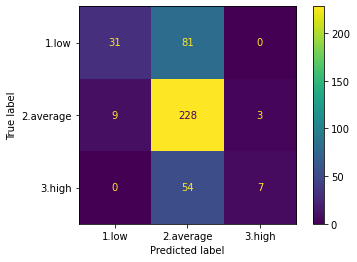

In [41]:
# train
c_poly_2 = SVC(kernel = 'poly', degree = 2)
m_poly_2 = c_poly_2.fit(X_prime, y)

print('Number of Support Vectors: ', m_poly_2.n_support_)

# predict
p = m_poly_2.predict(X_prime)

# evaluate
print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p, labels = y.cat.categories)

Let us make another model with the default radial kernel:

Number of Support Vectors:  [100 180  61]
              precision    recall  f1-score   support

       1.low       0.72      0.52      0.60       112
   2.average       0.69      0.91      0.79       240
      3.high       1.00      0.26      0.42        61

    accuracy                           0.71       413
   macro avg       0.81      0.56      0.60       413
weighted avg       0.75      0.71      0.68       413



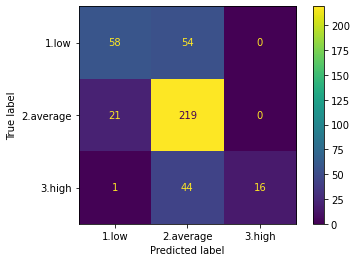

In [42]:
# train
c_radial = SVC()
m_radial = c_radial.fit(X_prime, y)

print('Number of Support Vectors: ', m_radial.n_support_)

# predict
p = m_radial.predict(X_prime)

# evaluate
print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p, labels = y.cat.categories)

We can see that both models have a very similar number of support vectors, so in a sense they are similarly complex. However, we can see some differences with respect to performance. The polynomial model is clearly biased towards the majority class `2.average`, and in fact it does a very poor job with `1.low` and, specially, with `3.high`. The radial model does a better job in both minority classes, as reflected for example by the F-scores and, more evidently, by the confusion matrices.

We may try and tune the budget hyperparameter through argument `C`. This argument specifies a _penalty_ when an instance is in the wrong side of the margin or in the wrong side of the hyperplane. Therefore, a high `C` translates into a narrow margin, while a low `C` translates into a wide margin. The default is `C = 1`, but we can control it when instantiating the classifier:

              precision    recall  f1-score   support

       1.low       0.83      0.77      0.80       112
   2.average       0.83      0.93      0.87       240
      3.high       0.93      0.62      0.75        61

    accuracy                           0.84       413
   macro avg       0.86      0.77      0.81       413
weighted avg       0.84      0.84      0.83       413



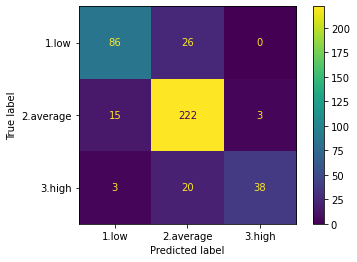

In [43]:
# train
c_radial_C_10 = SVC(C = 10)
m_radial_C_10 = c_radial_C_10.fit(X_prime, y)

# predict
p = m_radial_C_10.predict(X_prime)

# evaluate
print(classification_report(y, p))
ConfusionMatrixDisplay.from_predictions(y, p, labels = y.cat.categories)

Indeed, the model behaves much better. The confusion matrix indicates that this is mostly due to a better prediction of the minority classes `1.low` and `3.high`. What the optimal budget is, is a question we would need to answer through cross-validation or an independent test set.

## 8. Cross-Validation

When building classification models, there are certain hyperparameters that have to be set before training, such as criterion to build a tree, minimum number of observations per leaf, number of branches, cost of margin violations in SVM, type of kernel, etc. Sometimes we can let the training algorithm decide for us, but how do we know if we're overfitting? How do we know if we built the best model possible?

Cross-validation can help us here. In $k$-fold cross-validation, we systematically partition the available training data in two parts: one for training the model and the other one for validating its performance (refer back to the slides from the _Models_ lecture). If we do this $k$ times and average the performance across validation sets, we have an estimation for how well the model performs on unseen data. We can use these estimates to tune the value of a hyperparameter.

For example, we may be interested in determining how much we can prune a tree without significantly compromising its performance. In this case, we may plot performance by number of leaf nodes. In a random forest we might be interested in figuring out an optimal number of trees to grow. In an SVM, we might be interested in choosing the degree of a polynomial kernel, or the penalty for observations being on the wrong side of the hyperplane.

Scikit-learn contains [some functions](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers) to do automatic tuning of hyperparameters, but for illustration purposes we will implement our own cross-validation loop to make sensible decisions about hyperparameter values. We can use [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) from Scikit-learn, or even better, [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) to preserve the distribution of classes across splits.

In [44]:
from sklearn.model_selection import StratifiedKFold

def kfold_cv(X, y, k, H, cv_fun, random_state):
    """
    Do stratified k-fold cross-validation with a dataset, to check how a model behaves as a function
    of the values in H (eg. a hyperparameter such as tree depth, or polynomial degree).

    :param X: feature matrix.
    :param y: response column.
    :param k: number of folds.
    :param H: values of the hyperparameter to cross-validate.
    :param cv_fun: function of the form (X_train, y_train, X_valid, y_valid, h) to evaluate the model in one split,
        as a function of h. It must return a dictionary with metric score values.
    :param random_state: controls the pseudo random number generation for splitting the data.
    :return: a Pandas dataframe with metric scores along values in H.
    """
    kf = StratifiedKFold(n_splits = k, shuffle = True, random_state = random_state)
    pr = []  # to store global results

    # for each value h in H, do CV
    for h in H:
        scores = []  # to store the k results for this h
        # for each fold 1..K
        for train_index, valid_index in kf.split(X, y):
            # partition the data in training and validation
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            # call cv_fun to train the model and compute performance
            fold_scores = cv_fun(X_train, y_train, X_valid, y_valid, h)
            scores.append(fold_scores)

        rowMeans = pd.DataFrame(scores).mean(axis = 0)  # average scores across folds
        pr.append(rowMeans)  # append to global results

    pr = pd.DataFrame(pr).assign(_h = H)
    return pr

You are _not_ expected to fully understand this code. It’s fine if you just copy-paste it to use it yourself. What matters is that you know how to use it.

In order to use it, we need to provide the full feature matrix `X`, the response column `y`, the `k` number of folds, the list `H` of hyperparameter values that we want to evaluate, a function `cv_fun` that performs one iteration of the training-validation process for one data split, and finally a `random_state` for reproducibility of the data split process. We can implement our own `cv_fun`ctions following the signature below:

```python
def foo(X_train, y_train, X_valid, y_valid, h):
    # fit the model with the training data and hyperparameter h
    # compute evaluation statistics on the validation data
    # return a dictionary of scores
```

For example, we can write a function to fit a decision tree pruned to a certain number of leaf nodes:

In [45]:
def cv_tree_leaf(X_train, y_train, X_valid, y_valid, h):
    # create classifier to prune to h leaf nodes
    # we set the random state here as well for full reproducibility
    c = tree.DecisionTreeClassifier(max_leaf_nodes = h, random_state = 54321)
    m = c.fit(X_train, y_train)  # fit the model with the training set
    p = m.predict(X_valid)  # predict on the validation set

    # compute and return evaluation metric scores
    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro')}

And now we can use it with the `kfold_cv` function to try from 5 to 125 leaf nodes with 5-fold cross-validation:

In [46]:
pr = kfold_cv(X, y, k = 10, H = range(5, 50, 5), cv_fun = cv_tree_leaf, random_state = 12345)
pr

,accuracy,precision,recall,f,_h
0,0.624564,0.421782,0.429419,0.407406,5
1,0.629443,0.524977,0.463348,0.461693,10
2,0.627003,0.551536,0.489989,0.498812,15
3,0.609872,0.555292,0.485823,0.494129,20
4,0.607375,0.549690,0.473575,0.484485,25
5,0.602555,0.534943,0.474080,0.481643,30
6,0.607491,0.521922,0.475126,0.479337,35
7,0.612311,0.533189,0.479545,0.486607,40
8,0.597793,0.502536,0.474495,0.477132,45


The last column in `pr` corresponds to the hyperparameter values, and the other columns correspond to the average performance statistics computed in the validation sets. We can plot these data to visualize, for which it will be handy to turn them into longer format via Pandas' [`melt`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) (refer back to the _Data Wrangling_ lab for reference):

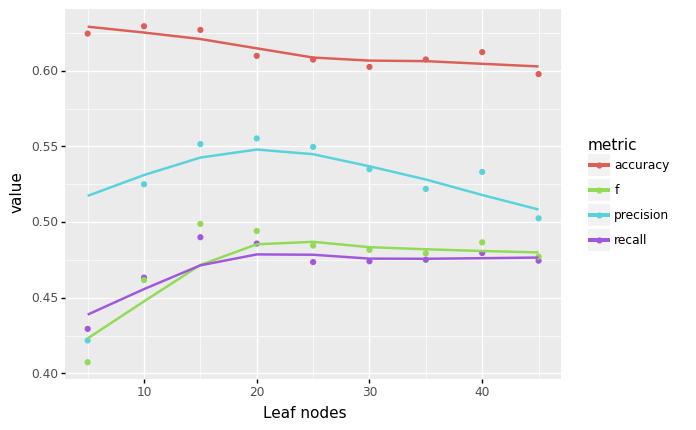

<ggplot: (18441021)>

In [47]:
pr = pr.melt(id_vars = '_h', var_name = 'metric')
ggplot(pr, aes('_h', 'value', color = 'metric')) +\
    geom_point() +\
    geom_smooth(se = False) +\
    labs(x = 'Leaf nodes')

First of all, the results confirm that the full tree we fitted earlier, `m_full`, was indeed overfitted, because the plot shows that the accuracy already peaks at around 0.63 with 10 leaf nodes. However, the low F-score suggests that this is because the model tends to predict the majority class. Increasing the number of leaves hurts accuracy a bit, but the increase in F-score indicates that the model has a better balance across classes. A sweet spot can be seen at just under `h = 20`. Therefore, our model selection would be pruning the tree with `max_leaf_nodes = 20` or so _when training on the full training dataset_.

The same idea can be followed for random forests to decide on the number of trees to grow. First we build a custom function to implement an iteration of the training-validation process:

In [48]:
def cv_rf_ntrees(X_train, y_train, X_valid, y_valid, h):
    c = RandomForestClassifier(n_estimators = h, random_state = 54321, \
                               n_jobs = -1) # set n_jobs to speed up by using more CPU cores
    m = c.fit(X_train, y_train)
    p = m.predict(X_valid)

    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro')}

And now we can use it with the `kfold_cv` function to try 25 to 400 trees with 5-fold cross-validation:

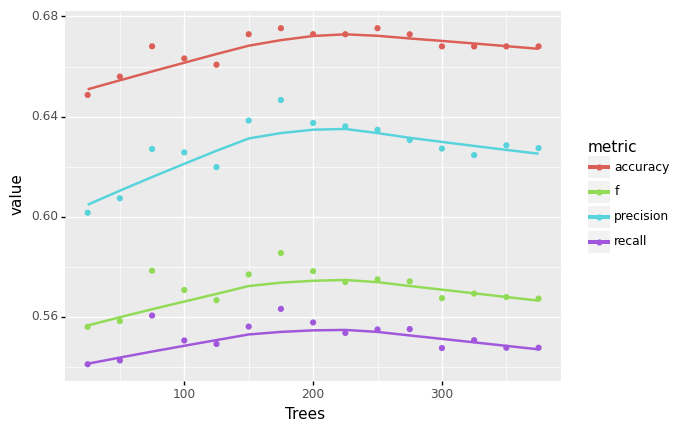

<ggplot: (18485068)>

In [49]:
pr = kfold_cv(X, y, k = 5, H = range(25, 400, 25), cv_fun = cv_rf_ntrees, random_state = 12345)

pr = pr.melt(id_vars = '_h', var_name = 'metric')
ggplot(pr, aes('_h', 'value', color = 'metric')) +\
    geom_point() +\
    geom_smooth(se = False) +\
    labs(x = 'Trees')

The results confirm that random forests perform better than single decision trees _on unseen data_, contrary to what we observed above on the training set alone. Based on the cross-validation results, we would choose about 200 or so trees.

For SVMs and, for instance, the optimal `C` argument, we would proceed similarly:

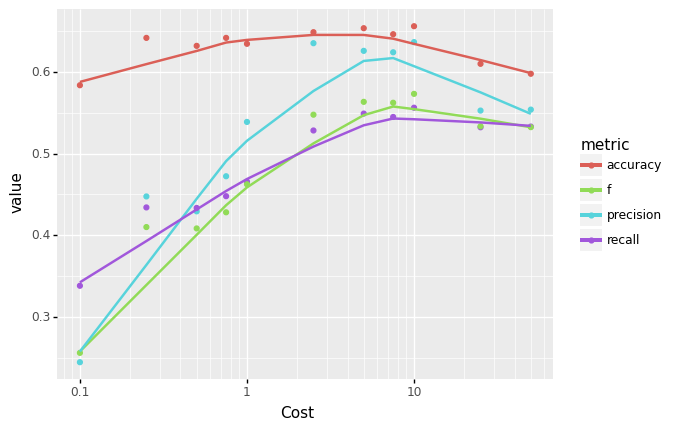

<ggplot: (18541818)>

In [50]:
def cv_svm_C(X_train, y_train, X_valid, y_valid, h):
    c = SVC(C = h)
    
    # Data has to be standardized according to the training set in the split
    # If we used the X_prime above, we would be `cheating` because the standardization itself is part of the model
    scaler = StandardScaler().fit(X_train)    
    m = c.fit(scaler.transform(X_train), y_train)
    p = m.predict(scaler.transform(X_valid))

    return {'accuracy': accuracy_score(y_valid, p),
            'precision': precision_score(y_valid, p, average = 'macro', zero_division = 0),
            'recall': recall_score(y_valid, p, average = 'macro'),
            'f': f1_score(y_valid, p, average = 'macro')}

pr = kfold_cv(X, y, k = 10, H = [.1, .25, .5, .75, 1, 2.5, 5, 7.5, 10, 25, 50], cv_fun = cv_svm_C, random_state = 12345)

pr = pr.melt(id_vars = '_h', var_name = 'metric')
ggplot(pr, aes('_h', 'value', color = 'metric')) +\
    geom_point() +\
    geom_smooth(se = False) +\
    scale_x_log10() +\
    labs(x = 'Cost')

It appears that a model trained with a penalty `C` around 10 is already about the best we can do with this dataset. Note how we explored values for `C` that span different orders of magnitude. This is typical when we don't have prior knowledge about what a suitable value could be; first we try different orders of magnitude and then fine-tune around the values that seems to be optimal. In our case, we should now check values between 1 and 20, for instance, in increments of 1.

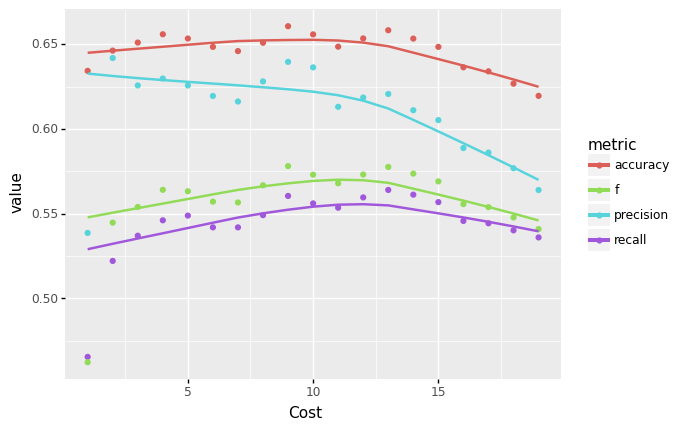

<ggplot: (18676517)>

In [51]:
pr = kfold_cv(X, y, k = 10, H = range(1, 20), cv_fun = cv_svm_C, random_state = 12345)

pr = pr.melt(id_vars = '_h', var_name = 'metric')
ggplot(pr, aes('_h', 'value', color = 'metric')) +\
    geom_point() +\
    geom_smooth(se = False) +\
    labs(x = 'Cost')

The optimal `C` seems to be around 10, at least in terms of F-score. More fine tuning would not be necessary because the trend here is pretty stable, and there's random noise due to the data splits anyway: cross-validation also has a random component to it, because the data are split randomly in training and validation sets. As an exercise, re-run the same cross-validation code with different `random_state`s and see how the results will be slightly different (large values of $k$ in k-fold cross validation will reduce this variability).